Read satellite data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
def read_satellite_data(veg_type, satellite):
    # Load vegetation class table
    veg_class = pd.read_csv('../data/veg_class_data/tables/veg_class.csv')
    df_satellite = pd.read_csv(f'../data/satellite_data/tables/phenology_climate/{satellite}.csv')
    df = pd.merge(df_satellite, veg_class, on=['latitude', 'longitude'], how='inner')
    # Filter for Forest classes
    if veg_type in (11, 12, 13, 14):
        df = df[df['veg_class'].isin([veg_type])]
    else:
        df = df[df['veg_class'].isin([11, 12, 13, 14])]
    
    # Separate climate/phenology columns by type
    eos_cols = [col for col in df.columns if 'eos' in col]
    t_cols = [col for col in df.columns if 'annual_t' in col]
    p_cols = [col for col in df.columns if 'annual_p' in col]
    sos_cols = [col for col in df.columns if 'sos' in col]

    if satellite == "avhrr":
        years = [str(y) for y in range(1982, 2017)]
    elif satellite == "modis":
        years = [str(y) for y in range(2001, 2024)]
        # Build boolean masks
        mask_sos = (df[sos_cols] < 0).any(axis=1)      # True if any sos < 0
        mask_eos = (df[eos_cols] > 365).any(axis=1)    # True if any eos > 365
        # Keep only rows that do NOT violate the conditions
        df = df[~(mask_sos | mask_eos)].copy()
    else:
        years = [str(y) for y in range(2013, 2023)]
        mask_sos = (df[sos_cols] < 0).any(axis=1)      # True if any sos < 0
        mask_eos = (df[eos_cols] > 365).any(axis=1)    # True if any eos > 365
        # Keep only rows that do NOT violate the conditions
        df = df[~(mask_sos | mask_eos)].copy()
        
    cols = years
    df = df[[col for col in eos_cols + t_cols + p_cols + sos_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()
    t_cols_df = [col for col in df.columns if 'annual_t' in col]
    df[t_cols_df] = df[t_cols_df] - 273.5  # Convert temperature
    df.columns = df.columns.str.replace(r'\D*(\d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)
    df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
    df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1)
    df['eos'] = df[[col for col in df.columns if 'eos' in col]].mean(axis=1)
    df['sos'] = df[[col for col in df.columns if 'sos' in col]].mean(axis=1)
    return df

In [2]:
## Calculate anomalies
def cal_anomalies(df):
    anom_parts = []
    
    # --- EOS anomalies ---
    eos_cols = [c for c in df.columns if c.startswith("eos_")]
    eos_anom = df[eos_cols].sub(df["eos"], axis=0)
    eos_anom.columns = [f"eos_anom_{c.split('_')[1]}" for c in eos_cols]
    anom_parts.append(eos_anom)
    
    # --- Temperature anomalies ---
    t_cols = [c for c in df.columns if c.startswith("annual_t_")]
    t_anom = df[t_cols].sub(df["annual_t"], axis=0)
    t_anom.columns = [f"annual_t_anom_{c.split('_')[2]}" for c in t_cols]
    anom_parts.append(t_anom)
    
    # --- Precipitation anomalies ---
    p_cols = [c for c in df.columns if c.startswith("annual_p_")]
    p_anom = df[p_cols].sub(df["annual_p"], axis=0)*1000
    p_anom.columns = [f"annual_p_anom_{c.split('_')[2]}" for c in p_cols]
    anom_parts.append(p_anom)
    
    # --- Join all anomaly blocks at once ---
    anom = pd.concat(anom_parts, axis=1)
    
    # Optionally merge into original
    df = pd.concat([df, anom], axis=1)


    return df

In [ ]:
## Plot anomalies, bar plot from filtered grid
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
from matplotlib.colors import ListedColormap

def plot_eos_anom_all_years(df, 
                            t_bins=np.arange(-3.5, 3.5, 0.1), 
                            p_bins=np.arange(-600, 600, 25),
                            trim=True, lower=5, upper=95, min_count=35):

    # Extract anomaly columns
    eos_cols = [c for c in df.columns if c.startswith("eos_anom_")]
    t_cols   = [c for c in df.columns if c.startswith("annual_t_anom_")]
    p_cols   = [c for c in df.columns if c.startswith("annual_p_anom_")]

    # Stack across all years
    eos_anom = df[eos_cols].to_numpy().ravel()
    t_anom   = df[t_cols].to_numpy().ravel()
    p_anom   = df[p_cols].to_numpy().ravel()

    # Remove NaN values
    mask = ~np.isnan(eos_anom) & ~np.isnan(t_anom) & ~np.isnan(p_anom)
    eos_anom, t_anom, p_anom = eos_anom[mask], t_anom[mask], p_anom[mask]

    # Trim EOS anomalies only
    if trim:
        e_low, e_high = np.percentile(eos_anom, [lower, upper])
        mask = (eos_anom >= e_low) & (eos_anom <= e_high)
        eos_anom, t_anom, p_anom = eos_anom[mask], t_anom[mask], p_anom[mask]

    # 2D binning: mean and count
    stat, x_edge, y_edge, _ = binned_statistic_2d(
        t_anom, p_anom, eos_anom, statistic="mean", bins=[t_bins, p_bins]
    )
    count, _, _, _ = binned_statistic_2d(
        t_anom, p_anom, eos_anom, statistic="count", bins=[t_bins, p_bins]
    )

    # Mask cells with fewer than min_count obs
    stat[count < min_count] = np.nan

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = ListedColormap(
        ["#0b3c68", "#165188", "#2066a8", "#4d91c4", "#8ec1da", 
         "#fbebe1", "#f6d6c2", "#d47264", "#c14d48", "#ae282c"]
    )

    from matplotlib import colors
    
    # Colormap with clipping at -12 and 12
    norm = colors.Normalize(vmin=-5, vmax=5, clip=True)
    pcm = ax.pcolormesh(x_edge, y_edge, stat.T, cmap=cmap, norm=norm, shading="auto", zorder=0)
    
    # Colorbar
    cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal', pad=0.2, shrink=0.8)
    cbar.set_label("EOS anomaly (days)", fontsize=14)
    
    # Custom ticks (no -12 / 12 labels, only inside values)
    cbar.set_ticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
    cbar.ax.tick_params(labelsize=12)

    cbar.set_label("EOS anomaly (days)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    # Axes labels
    ax.set_xlabel("MAT anomaly (°C)", fontsize=14)
    ax.set_ylabel("MAP anomaly (mm/year)", fontsize=14)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.tick_params(labelsize=12)
    ax.set_yticks([-400, -200, 0, 200, 400])

    # --- Compute mean/std per quadrant ---
    t_centers = (x_edge[:-1] + x_edge[1:]) / 2
    p_centers = (y_edge[:-1] + y_edge[1:]) / 2
    T_grid, P_grid = np.meshgrid(t_centers, p_centers, indexing='ij')  # shape = stat.shape
    
    quadrants = {
        "T>0, P>0": (T_grid > 0) & (P_grid > 0),
        "T>0, P<0": (T_grid > 0) & (P_grid < 0),
        "T<0, P>0": (T_grid < 0) & (P_grid > 0),
        "T<0, P<0": (T_grid < 0) & (P_grid < 0)
    }
    
    text_positions = {
        "T>0, P>0": (0.85, 0.90),
        "T>0, P<0": (0.85, 0.10),
        "T<0, P>0": (0.15, 0.90),
        "T<0, P<0": (0.15, 0.10)
    }

    bar_colors = {"Positive": "#d47264", "Negative": "#2066a8"}
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    for label, qmask in quadrants.items():
        grid_values = stat[qmask]
        grid_values = grid_values[~np.isnan(grid_values)]
    
        if len(grid_values) == 0:
            mean_val, std_val = np.nan, np.nan
            pos_count, neg_count = 0, 0
        else:
            mean_val, std_val = np.mean(grid_values), np.std(grid_values)
            pos_count = np.sum(grid_values > 0)
            neg_count = np.sum(grid_values < 0)
    
        total = pos_count + neg_count
        pos_pct = (pos_count / total) * 100 if total > 0 else 0
        neg_pct = (neg_count / total) * 100 if total > 0 else 0
    
        # # --- Place text ---
        x_pos, y_pos = text_positions[label]
    
        # --- Black rectangle behind bars ---
        from matplotlib.patches import Rectangle
        rect_width = 0.15
        rect_height = 0.15
        rect_x = x_pos - 0.11
        rect_y = y_pos - 0.07
        rect = Rectangle(
            (rect_x, rect_y),
            rect_width,
            rect_height,
            transform=ax.transAxes,
            color='white',  # or 'black' if desired
            zorder=1
        )
        ax.add_patch(rect)

        bar_colors = {"Positive": "#d47264", "Negative": "#2066a8"}
    
        
        # --- Place percentage texts ---
        x_pos, y_pos = text_positions[label]
                
        # Positive %
        ax.text(
            x_pos, y_pos + 0.01, f"{pos_pct:.1f}%",
            transform=ax.transAxes,
            fontsize=11,
            ha='center',
            va='bottom',
            color=bar_colors["Positive"],
            fontweight='bold'
        )
        
        # Negative %
        ax.text(
            x_pos, y_pos - 0.03, f"{neg_pct:.1f}%",
            transform=ax.transAxes,
            fontsize=11,
            ha='center',
            va='top',
            color=bar_colors["Negative"],
            fontweight='bold'
        )


    return fig


In [4]:
satellite = 'avhrr'

veg_type = 0
df = read_satellite_data(veg_type, satellite)

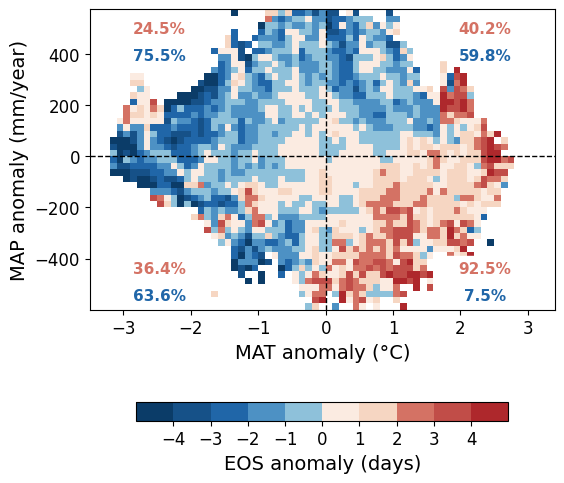

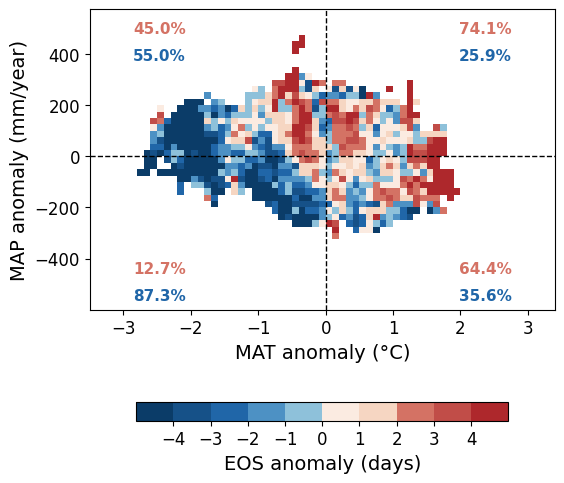

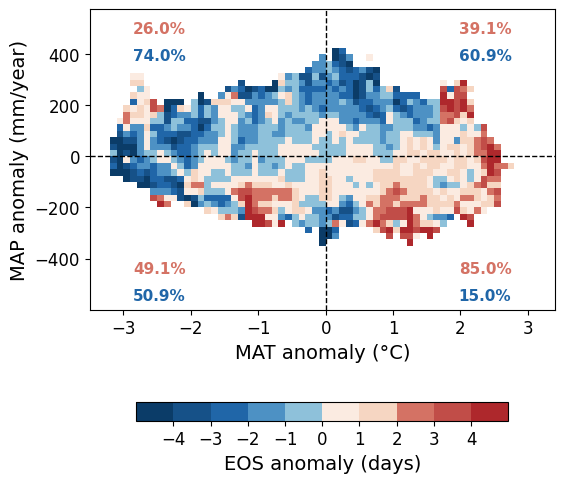

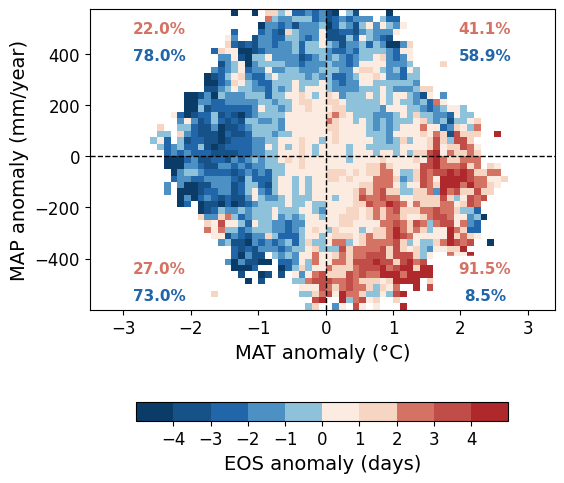

In [6]:
## All veg types & all years (grid for bar plot)
df_all = cal_anomalies(df)
fig = plot_eos_anom_all_years(df_all)
fig.savefig(f"../results/figure2/{satellite}/anomaly/all.png", dpi=300, bbox_inches='tight')

df_hot_dry = df[(df['annual_t']>7.25) & (df['annual_p']<0.9)].copy()
df_hot_dry = cal_anomalies(df_hot_dry)
fig = plot_eos_anom_all_years(df_hot_dry)
fig.savefig(f"../results/figure2/{satellite}/anomaly/hot-dry.png", dpi=300, bbox_inches='tight')

df_cold_dry = df[(df['annual_t']<7.25) & (df['annual_p']<0.9)].copy()
df_cold_dry = cal_anomalies(df_cold_dry)
fig = plot_eos_anom_all_years(df_cold_dry)
fig.savefig(f"../results/figure2/{satellite}/anomaly/cold-dry.png", dpi=300, bbox_inches='tight')

df_wet = df[(df['annual_p']>0.9)].copy()
df_wet = cal_anomalies(df_wet)
fig = plot_eos_anom_all_years(df_wet)
fig.savefig(f"../results/figure2/{satellite}/anomaly/wet.png", dpi=300, bbox_inches='tight')